The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 783 kB/s 
     |████████████████████████████████| 120 kB 48.2 MB/s 
     |████████████████████████████████| 1.6 MB 51.8 MB/s 
     |████████████████████████████████| 82 kB 663 kB/s 


# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these choices are made.
You might have even gotten the impression that these choices
are not especially important.
To the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics with greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parameterized by weights $\mathbf{W}^{(l)}$,
whose hidden layer output is $\mathbf{h}^{(l)}$ (let $\mathbf{h}^{(0)} = \mathbf{x}$),
our network can be expressed as:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ and thus } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

If all the hidden layer output and the input are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}^{(l)}$ as follows:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
and the gradient vector $\mathbf{v}^{(l)}$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $\mathbf{M}^{(l)}$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding gradient* problem);
or (ii) excessively small
(the *vanishing gradient* problem),
rendering learning impossible as parameters
hardly move on each update.


### (**Vanishing Gradients**)

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let's take a closer look at the sigmoid
to see why it can cause vanishing gradients.


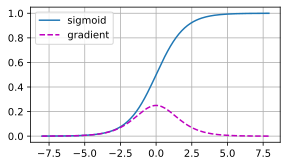

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, (**the sigmoid's gradient vanishes
both when its inputs are large and when they are small**).
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at some layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### [**Exploding Gradients**]

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw 100 Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens due to the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


In [3]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 1.5611, -0.3991, -0.0327, -0.1587],
        [-0.1949,  2.9766,  0.3598, -0.8464],
        [-0.3648,  0.1009,  1.4814,  0.9380],
        [ 0.2111, -0.0289, -0.0475,  0.9858]])
after multiplying 100 matrices
 tensor([[-7.3822e+22, -2.4001e+23,  1.3841e+23, -3.8033e+23],
        [-1.6034e+23, -5.2129e+23,  3.0062e+23, -8.2607e+23],
        [ 1.6750e+22,  5.4457e+22, -3.1405e+22,  8.6295e+22],
        [ 4.5489e+22,  1.4789e+23, -8.5290e+22,  2.3436e+23]])


### Breaking the Symmetry

Another problem in neural network design
is the symmetry inherent in their parametrization.
Assume that we have a simple MLP
with one hidden layer and two units.
In this case, we could permute the weights $\mathbf{W}^{(1)}$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first hidden unit vs. the second hidden unit.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Consider the aforementioned one-hidden-layer MLP
with two hidden units.
For illustration,
suppose that the output layer transforms the two hidden units into only one output unit.
Imagine what would happen if we initialized
all of the parameters of the hidden layer
as $\mathbf{W}^{(1)} = c$ for some constant $c$.
In this case, during forward propagation
either hidden unit takes the same inputs and parameters,
producing the same activation,
which is fed to the output unit.
During backpropagation,
differentiating the output unit with respect to parameters $\mathbf{W}^{(1)}$ gives a gradient whose elements all take the same value.
Thus, after gradient-based iteration (e.g., minibatch stochastic gradient descent),
all the elements of $\mathbf{W}^{(1)}$ still take the same value.
Such iterations would
never *break the symmetry* on its own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while minibatch stochastic gradient descent would not break this symmetry,
dropout regularization (to be introduced later) would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
As we will see later,
additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution
to initialize the values of our weights.
If we do not specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.






### Xavier Initialization
:label:`subsec_xavier`

Let's look at the scale distribution of
an output $o_{i}$ for some fully connected layer
*without nonlinearities*.
With $n_\mathrm{in}$ inputs $x_j$
and their associated weights $w_{ij}$ for this layer,
an output is given by

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

The weights $w_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$.
Note that this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist.
For now, let's assume that the inputs to the layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $w_{ij}$ and independent of each other.
In this case, we can compute the mean and variance of $o_i$ as follows:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\mathrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the layers closer to the output.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\mathrm{out} \sigma^2 = 1$,
where $n_\mathrm{out}$ is the number of outputs of this layer.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier initialization*,
named after the first author of its creators :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$.
We can also adapt Xavier's intuition to
choose the variance when sampling weights
from a uniform distribution.
Note that the uniform distribution $U(-a, a)$ has variance $\frac{a^2}{3}$.
Plugging $\frac{a^2}{3}$ into our condition on $\sigma^2$
yields the suggestion to initialize according to

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

Though the assumption for nonexistence of nonlinearities
in the above mathematical reasoning
can be easily violated in neural networks,
the Xavier initialization method
turns out to work well in practice.


### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
For instance,
Xiao et al. demonstrated the possibility of training
10000-layer neural networks without architectural tricks
by using a carefully-designed initialization method :cite:`Xiao.Bahri.Sohl-Dickstein.ea.2018`.

If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across or even invent
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

* Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
* Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
* ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.
* Random initialization is key to ensure that symmetry is broken before optimization.
* Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry requiring breaking besides the permutation symmetry in an MLP's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on layerwise adaptive rate scaling  for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)
